In [1]:
!pip install lightgbm

In [ ]:
from azure.storage.blob import BlobServiceClient
import pandas as pd

# Replace with your actual connection string
connection_string = "DefaultEndpointsProtocol=https;AccountName=frauddetectionstorage1;AccountKey=your_account_key_here;EndpointSuffix=core.windows.net"

# Connect to Azure Blob Storage
blob_service_client = BlobServiceClient.from_connection_string(connection_string)
container_client = blob_service_client.get_container_client("fraud-data")

# Download the preprocessed data
for file in ["X_train.csv", "X_test.csv", "y_train.csv", "y_test.csv"]:
    blob_client = container_client.get_blob_client(file)
    with open(file, "wb") as download_file:
        download_file.write(blob_client.download_blob().readall())

# Load the data into DataFrames
X_train = pd.read_csv("X_train.csv")
X_test = pd.read_csv("X_test.csv")
y_train = pd.read_csv("y_train.csv")
y_test = pd.read_csv("y_test.csv")

# Ensure y_train and y_test are 1D arrays (required for scikit-learn)
y_train = y_train.values.ravel()
y_test = y_test.values.ravel()

print("Training set shape:", X_train.shape)
print("Testing set shape:", X_test.shape)

Training set shape: (227845, 30)
Testing set shape: (56962, 30)


In [3]:
import lightgbm as lgb
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report

# Initialize the LightGBM model
model = lgb.LGBMClassifier(random_state=42)

# Train the model
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]  # Probabilities for the positive class

In [4]:
# Calculate evaluation metrics
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)

# Print the metrics
print("Precision:", precision)
print("Recall:", recall)
print("F1-Score:", f1)
print("AUC-ROC:", roc_auc)

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", conf_matrix)

# Classification Report
print("Classification Report:\n", classification_report(y_test, y_pred))

Precision: 0.1934156378600823
Recall: 0.47959183673469385
F1-Score: 0.2756598240469208
AUC-ROC: 0.6159671697885682
Confusion Matrix:
 [[56668   196]
 [   51    47]]
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.19      0.48      0.28        98

    accuracy                           1.00     56962
   macro avg       0.60      0.74      0.64     56962
weighted avg       1.00      1.00      1.00     56962



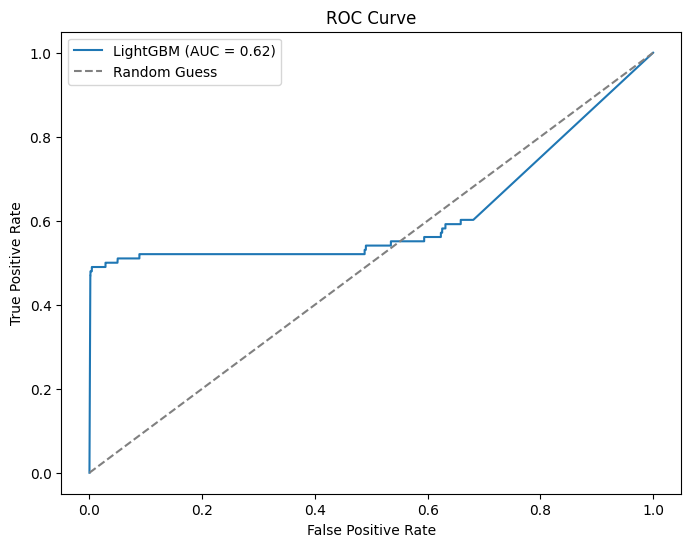

In [5]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"LightGBM (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray", label="Random Guess")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

In [6]:
import joblib

# Save the model locally
model_filename = "lightgbm_model.pkl"
joblib.dump(model, model_filename)

# Upload the model to Azure Blob Storage
blob_client = container_client.get_blob_client(model_filename)
with open(model_filename, "rb") as data:
    blob_client.upload_blob(data, overwrite=True)

print("LightGBM model saved and uploaded to Azure Blob Storage.")

LightGBM model saved and uploaded to Azure Blob Storage.
